Following the array calibration experiment Lena and I did at the LMU corridor, it's turned out that there're errors of upto 3metres, and that too systematic errors with the TOADSuite predicting *larger* errors than expected. This doesn't match with what is expected from the Aubauer thesis, and in general an error of 30% in radial distance estimation (3m overestimation over 10m radial distance) is not quite expected.

For more details on the kinds of error seen in the calibration experiment - see Lena's Master thesis appendix report and the report sent on 2020-02-03 over orn.mpg.de emails. 


This report will generate audiofiles for Lena to test the effect of various parameters on in the TOADsuite. The 4-channel 60cm tristar array will be used in all simulations. 

-- Thejasvi Beleyur, Janurary 2020, Acoustic and Functional Ecology group, MPI for Ornithology, Seewiesen

### Factors that might contribute to the weird patterns. 
#### 1) SNR:
The signal-to-noise ratio(SNR) in the recordings is one obvious factor that comes to mind. I now have also reason to believe that along with the overall SNR, the *discrepancy* in SNR across microphones may cause systematic over/under estimations of radial distance. 

I will simulate a situation with 

SNR_uniform: a range of overall SNR's in the recordings. All channels have the same SNR.

SNR_discrepancy: a range of SNR discrepancies between microphones. Each channel has a different SNR


#### 2)Microphone displacement
Microphones do move sometimes during recording, and this means there is an error in position specified for calculations.Lena suggested that a displacement of about $\pm$ 2cm is realistic. The scenarios simulated will be:

Mic0_positionerror : The central mic's position is misspecified 

Mic3_positionerror : The 'topmost' mic position is misspecified.

In [1]:
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.spatial as spl
import soundfile as sf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams['agg.path.chunksize'] = 100000

In [2]:
%matplotlib notebook

In [10]:
rms = lambda X: np.sqrt(np.mean(X**2.0))
dB = lambda X: 20*np.log10(abs(X))
def generate_emitted_positions():
    '''Creates a hemisphere of positions matching those done in the LMU corridor
    
    Returns
    --------
    emitted_points : Npositions x 3 np.array with x,y,z co-ordinates
    '''

    radius = np.array([3, 4.5, 6, 8.5, 10])
    elevation = np.radians([-60,-30,0,30,60])
    azimuth = np.radians([0,30,60])

    all_r_theta_phis = np.array(np.meshgrid(radius,elevation,azimuth)).T.reshape(-1,3)
    emitted_points = np.zeros((radius.size*elevation.size*azimuth.size,3))

    for row, each_pos in enumerate(all_r_theta_phis):
        r, theta, phi = each_pos
        # converting spherical to cartesian coordinates
        x = r*np.cos(theta)*np.sin(phi)
        y = r*np.cos(theta)*np.cos(phi)
        z = r*np.sin(theta)
        xyz = [x,y,z]
        emitted_points[row,:] = xyz
    return emitted_points


def calculate_mic_arrival_times(emit_points, **kwargs):
    '''
    
    Parameters
    ------------
    emit_points: Npoints x 3  np.array  with x,y,z of the emitted positions

    v_sound : float>0
             Speed of sound, defaults to 330m/s

    Keyword Arguments
    --------------------
    mic_positions : Nmicsx3 np.array with x,y,z of each microphone 
                Defaults to the standard 60cm tristar array. 

    ipi : float>0
          Interpulse interval between emissions. Defaults to 0.1 seconds            
    
    v_sound : float>0
             Speed of sound, defaults to 338.0m/s
            
    '''
    ipi = kwargs.get('ipi',0.1)
    v_sound = kwargs.get('v_sound', 338)
    t_emit = np.arange(0.1, (emit_points.shape[0]+1)*ipi, ipi)
    rec_durn = t_emit[-1] + 0.1

    # define mic positions  and calculate the radial distance to the mics
    standard_tristar = np.array(([0, 0, 0],
                                 [-0.52, 0.0, -0.3],
                                 [0.52, 0.0, -0.3],
                                 [0, 0.0, 0.6]))

    mic_positions = kwargs.get('mic_positions', standard_tristar)

    # calculate mic-bat distances for each call;
    t_calls_at_mics = np.zeros((t_emit.size, mic_positions.shape[0]))
    for mic_num, each_mic_pos in enumerate(mic_positions):
        row = 0
        print(mic_num)
        for t_call, each_pos in zip(t_emit, emit_points):
            t_calls_at_mics[row, mic_num] = spl.distance.euclidean(each_pos, each_mic_pos)/v_sound + t_call
            row += 1
    return t_calls_at_mics


def make_bat_call(**kwargs):
    '''
    '''
    fs = kwargs['fs']
    # create bat call that will be put into the audio
    start_f, end_f = 96000, 15000
    call_durn = kwargs.get('call_durn',0.003)
    t = np.linspace(0, call_durn, int(fs * call_durn))
    bat_call = signal.chirp(t, start_f, t[-1], end_f, 'logarithmic') * 0.5
    bat_call *= signal.tukey(bat_call.size, 0.5)
    return bat_call



def assign_call_to_mic(audio_channel, call, t_arrivals,**kwargs):
    '''
    '''
    for each_call in t_arrivals:
        start_sample = int(each_call * kwargs['fs'])
        audio_channel[start_sample:start_sample + call.size] += call

    return audio_channel

def create_audio_for_mic_arrival_times(t_arrivals, **kwargs):
    '''
    
    Keyword Arguments
    -------------------
    background_noise : float. 
                       db rms of white noise. Defaults to -90 dB rms re 1.
    '''
    
    # create the WAV files :
    fs = kwargs.get('fs',500000)
    n_channels = t_arrivals.shape[1]
    rec_durn = np.max(t_arrivals) + 0.05 # recording ends 50 milliseconds after start of last arriving call
    audio = np.zeros((int(rec_durn * fs), n_channels))
    
    background_noise = kwargs.get('background_noise', -60)
    audio += np.random.normal(0, 10 ** (background_noise/20.0), audio.size).reshape(-1, 4)
    audio = np.float32(audio)
    
    bat_call = make_bat_call(**kwargs)
    target_SNR = kwargs.get('call_SNR', 50)
    print('dbrms bat call', dB(rms(bat_call)))
    adjusted_rms_batcall = adjust_rms_to_reach_SNR(bat_call, target_SNR, audio)
    print('dbrms onlyaudio', dB(rms(audio)))
    print('dbrms adjusted bat call', dB(rms(adjusted_rms_batcall)))
    

    for each_channel in range(t_arrivals.shape[1]):
        assign_call_to_mic(audio[:, each_channel], adjusted_rms_batcall,
                           t_arrivals[:, each_channel],**kwargs)

    audio *= 0.9

    return audio

def adjust_rms_to_reach_SNR(bat_call, SNR, empty_audio):
    '''
    '''
    rms_empty = rms(empty_audio)
    current_SNR = dB(rms(bat_call)) - dB(rms(empty_audio))
    
    required_gain = SNR - current_SNR
    adjusted_bat_call = bat_call*10**(required_gain/20.0)
    
    return adjusted_bat_call

def simulate_audio_for_LMU_experiment(**kwargs):
    '''
    '''
    
    points= generate_emitted_positions()
    tcalls = calculate_mic_arrival_times(points, **kwargs)
    audio = create_audio_for_mic_arrival_times(tcalls,**kwargs)
    return audio 
    

In [11]:
LMU_audio = simulate_audio_for_LMU_experiment(fs=500000, call_SNR=30, v_sound=338)

0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -59.99917507171631)
('dbrms adjusted bat call', -29.99917507171631)


### Let's make some plots - just to show that the output is sensible. We expect the same call to arrive at different times across the channels 

In [16]:
one_call = make_bat_call(fs=500000)
dyn_range_value = 20*np.log10(np.max(abs(one_call))) - 80

<IPython.core.display.Javascript object>


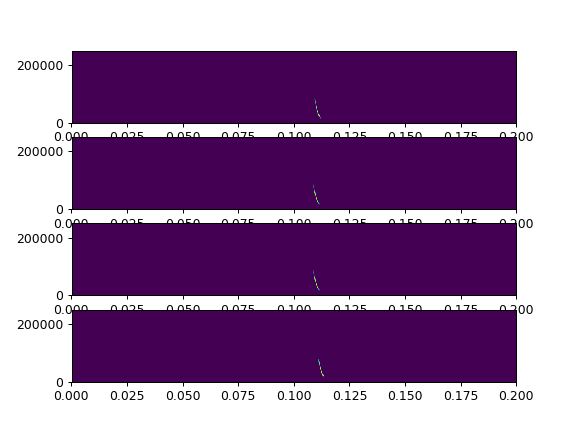

In [17]:
fs = 500000
plt.figure()
a0 = plt.subplot(411)
plt.specgram(LMU_audio[:fs/5,0], Fs=500000, vmin=dyn_range_value);
for plot in [2,3,4]:
    plt.subplot(410+plot, sharex=a0)
    plt.specgram(LMU_audio[:fs/5,plot-1], Fs=500000, vmin=dyn_range_value);

## Simulating the effect of Uniform  SNR variation for all channels. 

I will simulate the effect of uniform SNr alteration on all channels. The SNR values chosen will be: 0,6,12,18,24,30 dB (20log10).

In [18]:
# calculate the dBrms of the bat call by itself:
call_SNR_values = [0, 6, 12, 18, 24, 30]
audio_fs = 500000

SNR_template_filename = 'effect_of_positions_SNR_'


for each_SNR in call_SNR_values:
    LMU_audio = simulate_audio_for_LMU_experiment(fs=audio_fs, call_SNR=each_SNR)
    file_name = SNR_template_filename + ('{%d}'%each_SNR)+ '.WAV'
    sf.write(file_name, LMU_audio, samplerate=audio_fs)

0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -60.00044822692871)
('dbrms adjusted bat call', -60.000448226928704)
0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -59.99732971191406)
('dbrms adjusted bat call', -53.99732971191406)
0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -59.99995708465576)
('dbrms adjusted bat call', -47.99995708465576)
0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -59.99876022338867)
('dbrms adjusted bat call', -41.99876022338867)
0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -60.001182556152344)
('dbrms adjusted bat call', -36.001182556152344)
0
1
2
3
('dbrms bat call', -10.661070282966826)
('dbrms onlyaudio', -60.00133514404297)
('dbrms adjusted bat call', -30.00133514404297)


<IPython.core.display.Javascript object>


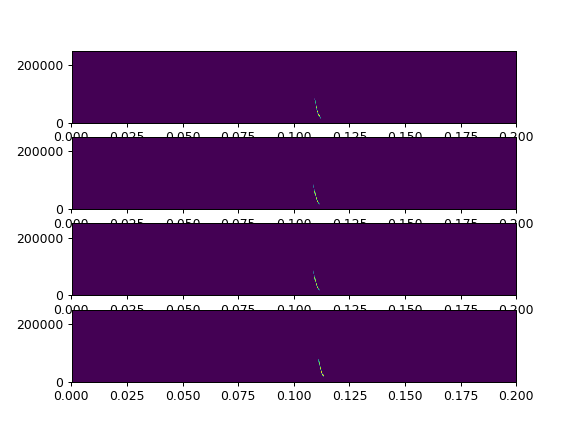

In [19]:
fs = 500000
plt.figure()
a0 = plt.subplot(411)
plt.specgram(LMU_audio[:fs/5,0], Fs=500000, vmin=dyn_range_value);
for plot in [2,3,4]:
    plt.subplot(410+plot, sharex=a0)
    plt.specgram(LMU_audio[:fs/5,plot-1], Fs=500000, vmin=dyn_range_value);

### Simulating the effect of SNR *discrepancy across channels*
Now I will simulate the effect of SNR discrepancy across channels. 